### Introduction
This notebook is an experiment of building a model that will predict if a rookie player will last at least 5 years in the league based on his stats.

In the National Basketball Association (NBA), a rookie is any player who has never played a game in the NBA until that year. At the end of the season the NBA awards the best rookie with the NBA Rookie of the Year Award.

Moving to the NBA league is a big deal for any basketball player. Sport commentators and fans are very excited to follow the start of their careers and guess how they will perform in the future.

In this experiment, AdaBoost Classifier model is used.

In [32]:
import pandas as pd
import numpy as np

## Custom Libraries
import os
import sys
sys.path.append(os.path.abspath('..'))
from src.common_lib import DataReader, NBARawData
from src.models.aj_metrics import confusion_matrix, plot_roc, visualise_accuray
from src.features.build_features import add_knn_feature

# Models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV, KFold

# Accuracy Measures
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, accuracy_score, roc_curve, auc
from joblib import dump
import matplotlib.pyplot as plt


from collections import Counter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Raw Data

In [33]:
# Instantiate the custom data reader class
data_reader = DataReader()

# Load Raw Train Data
train_df = data_reader.read_data(NBARawData.TRAIN)

# Load Test Raw Data
test_df = data_reader.read_data(NBARawData.TEST)

### Build K-nearest Neighbours Model and Add Knn Feature to the Training Set

In [34]:
knn = KNeighborsClassifier(n_neighbors=2)


train_df_copy = train_df.copy()
target = train_df_copy['TARGET_5Yrs']
train_df_copy = train_df_copy.drop(['Id_old', 'Id', 'TARGET_5Yrs'], axis = 1)

knn.fit(train_df_copy, target)
train_df_with_new_feature = add_knn_feature(knn, train_df_copy, [])

# Visualise the Accuracy as a WHOLE according to KNN classifier
confusion_matrix(target, train_df_with_new_feature['Knn'])

,pred:0,pred:1
true:0,1331,0
true:1,986,5683


In [183]:
train_df_with_new_feature.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,Knn
0,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,0
3,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


### Add Knn Feature to the Test set

In [35]:
test_dataframe = add_knn_feature(knn, test_df , ['Id_old', 'Id'] )
test_dataframe.head()
test_df.shape

(3799, 21)

Index(['GP', 'MIN', 'FG%', '3P Made', '3P%', 'FTM', 'FT%', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV', 'Knn', 'TARGET_5Yrs'],
      dtype='object')


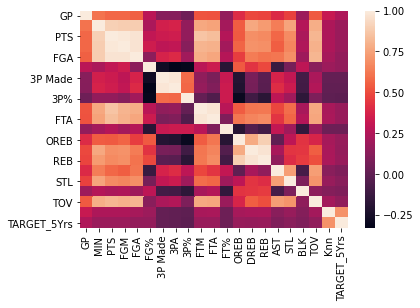

In [37]:
train_df_with_new_feature['TARGET_5Yrs'] = target

# Invoke the common function to do feature selection by correlation, Please run only once
# Features with corr > 0.9 are removed
selected_features = data_reader.select_feature_by_correlation(train_df_with_new_feature, [])
print(selected_features)

### Split Data and Build Adaboost Classifier with GridSearch

In [38]:
# SPlit the data
train_df_new = train_df_with_new_feature[selected_features]
X_train, X_val, y_train, y_val = data_reader.split_data(train_df_new)

# Build Ada Boost Model
abc = AdaBoostClassifier()

# Save the model
dump(abc, '../models/adaboost_knn.joblib')

crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)
search_grid = {
     'n_estimators': np.arange(10,300,10),
     'learning_rate': [0.01, 0.05, 0.1, 1],
 }

model=GridSearchCV(estimator=abc,param_grid=search_grid,scoring='accuracy',n_jobs=1,cv=crossvalidation)
model

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=AdaBoostClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 1],
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290])},
             scoring='accuracy')

### Train the Model and See the best parameters

In [40]:
model.fit(X_train,y_train)
model.best_params_ # {'learning_rate': 0.01, 'n_estimators': 10}
model.best_estimator_   # AdaBoostClassifier(learning_rate=0.01, n_estimators=10)
#model.best_score_ # 0.8784375000000001

AdaBoostClassifier(learning_rate=0.01, n_estimators=10)

### Retrain the Model with suggested parameters

Accuracy Score: 0.8784375


,pred:0,pred:1
true:0,1074,0
true:1,778,4548


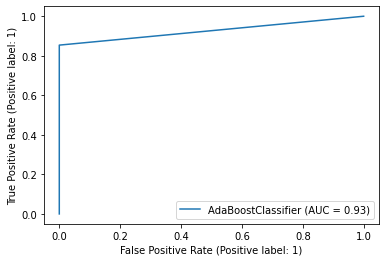

In [48]:
## Retrain the model again
model_2 = AdaBoostClassifier(n_estimators=10, learning_rate = 0.01)
model_2.fit(X_train, y_train)

y_pred = model_2.predict(X_train)

visualise_accuray(model_2, X_train, y_train, y_pred)
confusion_matrix(y_train, y_pred)

### Performance of Retrained Model on Validation Set

Accuracy Score: 0.87


,pred:0,pred:1
true:0,257,0
true:1,208,1135


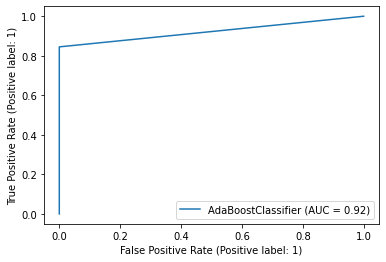

In [42]:
# Model 2 on Val Data
y_pred = model_2.predict(X_val)

visualise_accuray(model_2, X_val, y_val, y_pred)
confusion_matrix(y_val, y_pred)

### Model Prediction on Test Data

In [47]:
# Extract the features which were used in model building
features_without_target = np.delete(selected_features, 14)
test_dataframe = test_dataframe[features_without_target]

y_test_proba =model_2.predict_proba(test_dataframe)[:,1]


final_prediction_test = pd.DataFrame({'Id': range(0,3799), 'TARGET_5Yrs': [p for p in y_test_proba]})
final_prediction_test.to_csv("../reports/tin_submission_adaboost_with_knn_selFeatures_cv.csv", index=False)

final_prediction_test.head(10)

,Id,TARGET_5Yrs
0,0,1.000000
1,1,1.000000
2,2,1.000000
3,3,1.000000
4,4,1.000000
5,5,1.000000
6,6,1.000000
7,7,0.423532
8,8,0.423532
9,9,1.000000
